# 🎨 Sampling Visualization

You can use this notebook to visualize your trained models.

In [6]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

plt.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Load a Trained Model

First, let's load a trained checkpoint. Update the path to your trained model.

In [7]:
import yaml
from src.models import create_model_from_config
# from src.methods import DDPM, FlowMatching
from src.methods import DDPM
from src.utils import EMA

def load_model(checkpoint_path, method='ddpm'):
    """Load a trained model from checkpoint."""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    config = checkpoint['config']

    # Create model
    model = create_model_from_config(config).to(device)
    model.load_state_dict(checkpoint['model'])

    # Load EMA weights
    ema = EMA(model, decay=config['training']['ema_decay'])
    ema.load_state_dict(checkpoint['ema'])
    ema.apply_shadow()  # Use EMA weights

    # Create method
    if method == 'ddpm':
        diffusion = DDPM.from_config(model, config, device)
    else:
        diffusion = FlowMatching.from_config(model, config, device)

    diffusion.eval_mode()
    return diffusion, config

In [8]:
# ============================================
# UPDATE THIS PATH TO YOUR TRAINED MODEL
# ============================================
CHECKPOINT_PATH = '/home/arnavgoe/10799-Diffusion/cmu-10799-diffusion/logs/ddpm_20260125_131450/checkpoints/ddpm_final.pt'
METHOD = 'ddpm'  # 'ddpm' or 'flow_matching' or any of your custom method names

import os

if os.path.exists(CHECKPOINT_PATH):
    # Load trained model
    print(f"Loading trained model from {CHECKPOINT_PATH}...")
    diffusion, config = load_model(CHECKPOINT_PATH, METHOD)
    print(f"✓ Loaded {METHOD} model")
else:
    # Create untrained model for demonstration
    print("⚠️ No checkpoint found. Creating untrained model for demonstration.")
    print("   Samples will be random noise - train a model first for real results!")
    print()
    
    with open('YOUR_MODEL_CONFIG.yaml', 'r') as f:
        config = yaml.safe_load(f)
    
    from src.models import create_model_from_config
    from src.methods import DDPM, FlowMatching
    
    model = create_model_from_config(config).to(device)
    diffusion = DDPM.from_config(model, config, device) # Change DDPM to your method class name
    diffusion.eval_mode()

Loading trained model from /home/arnavgoe/10799-Diffusion/cmu-10799-diffusion/logs/ddpm_20260125_131450/checkpoints/ddpm_final.pt...
✓ Loaded ddpm model


In [9]:
# Display model information
def count_parameters(model):
    """Count total and trainable parameters in a model."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Get the underlying model
if hasattr(diffusion, 'model'):
    model = diffusion.model
else:
    # If diffusion doesn't have a model attribute, use it directly
    model = diffusion

total_params, trainable_params = count_parameters(model)

print("=" * 60)
print("MODEL INFORMATION")
print("=" * 60)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / (1024**2):.2f} MB (FP32)")
print(f"Method: {METHOD}")
if os.path.exists(CHECKPOINT_PATH):
    print(f"Checkpoint: {CHECKPOINT_PATH}")
else:
    print("Checkpoint: None (untrained model)")
print("=" * 60)

MODEL INFORMATION
Total parameters: 19,851,203
Trainable parameters: 19,851,203
Model size: 75.73 MB (FP32)
Method: ddpm
Checkpoint: /home/arnavgoe/10799-Diffusion/cmu-10799-diffusion/logs/ddpm_20260125_131450/checkpoints/ddpm_final.pt


This is the model size that I used to get a decently working model (KID around 0.0035, FID around 8). I trained it for around 5 hours on 4 L40S GPUs. I don't think you need 4 GPUs for this model, I have later trained the same model on a single L40S GPU and it was also able to work decently well after roughly the same amount of time (KID around 0.0039), I think you can probably train this model on a single L40S GPU for even shorter and still get a ok model (but this is not an excuse for you to procrastinate on starting the homework! Start early so that you have enough time to debug!!)

## 2. DDPM Sampling

The standard DDPM sampling algorithm iteratively denoises from pure noise. I have included a grid sampled from the model that I showed above for your reference here.

Sampling with ddpm...
This may take a minute...


DDPM Sampling: 100%|██████████| 1000/1000 [00:16<00:00, 60.31it/s]


Trajectory shape: torch.Size([1001, 16, 3, 64, 64])


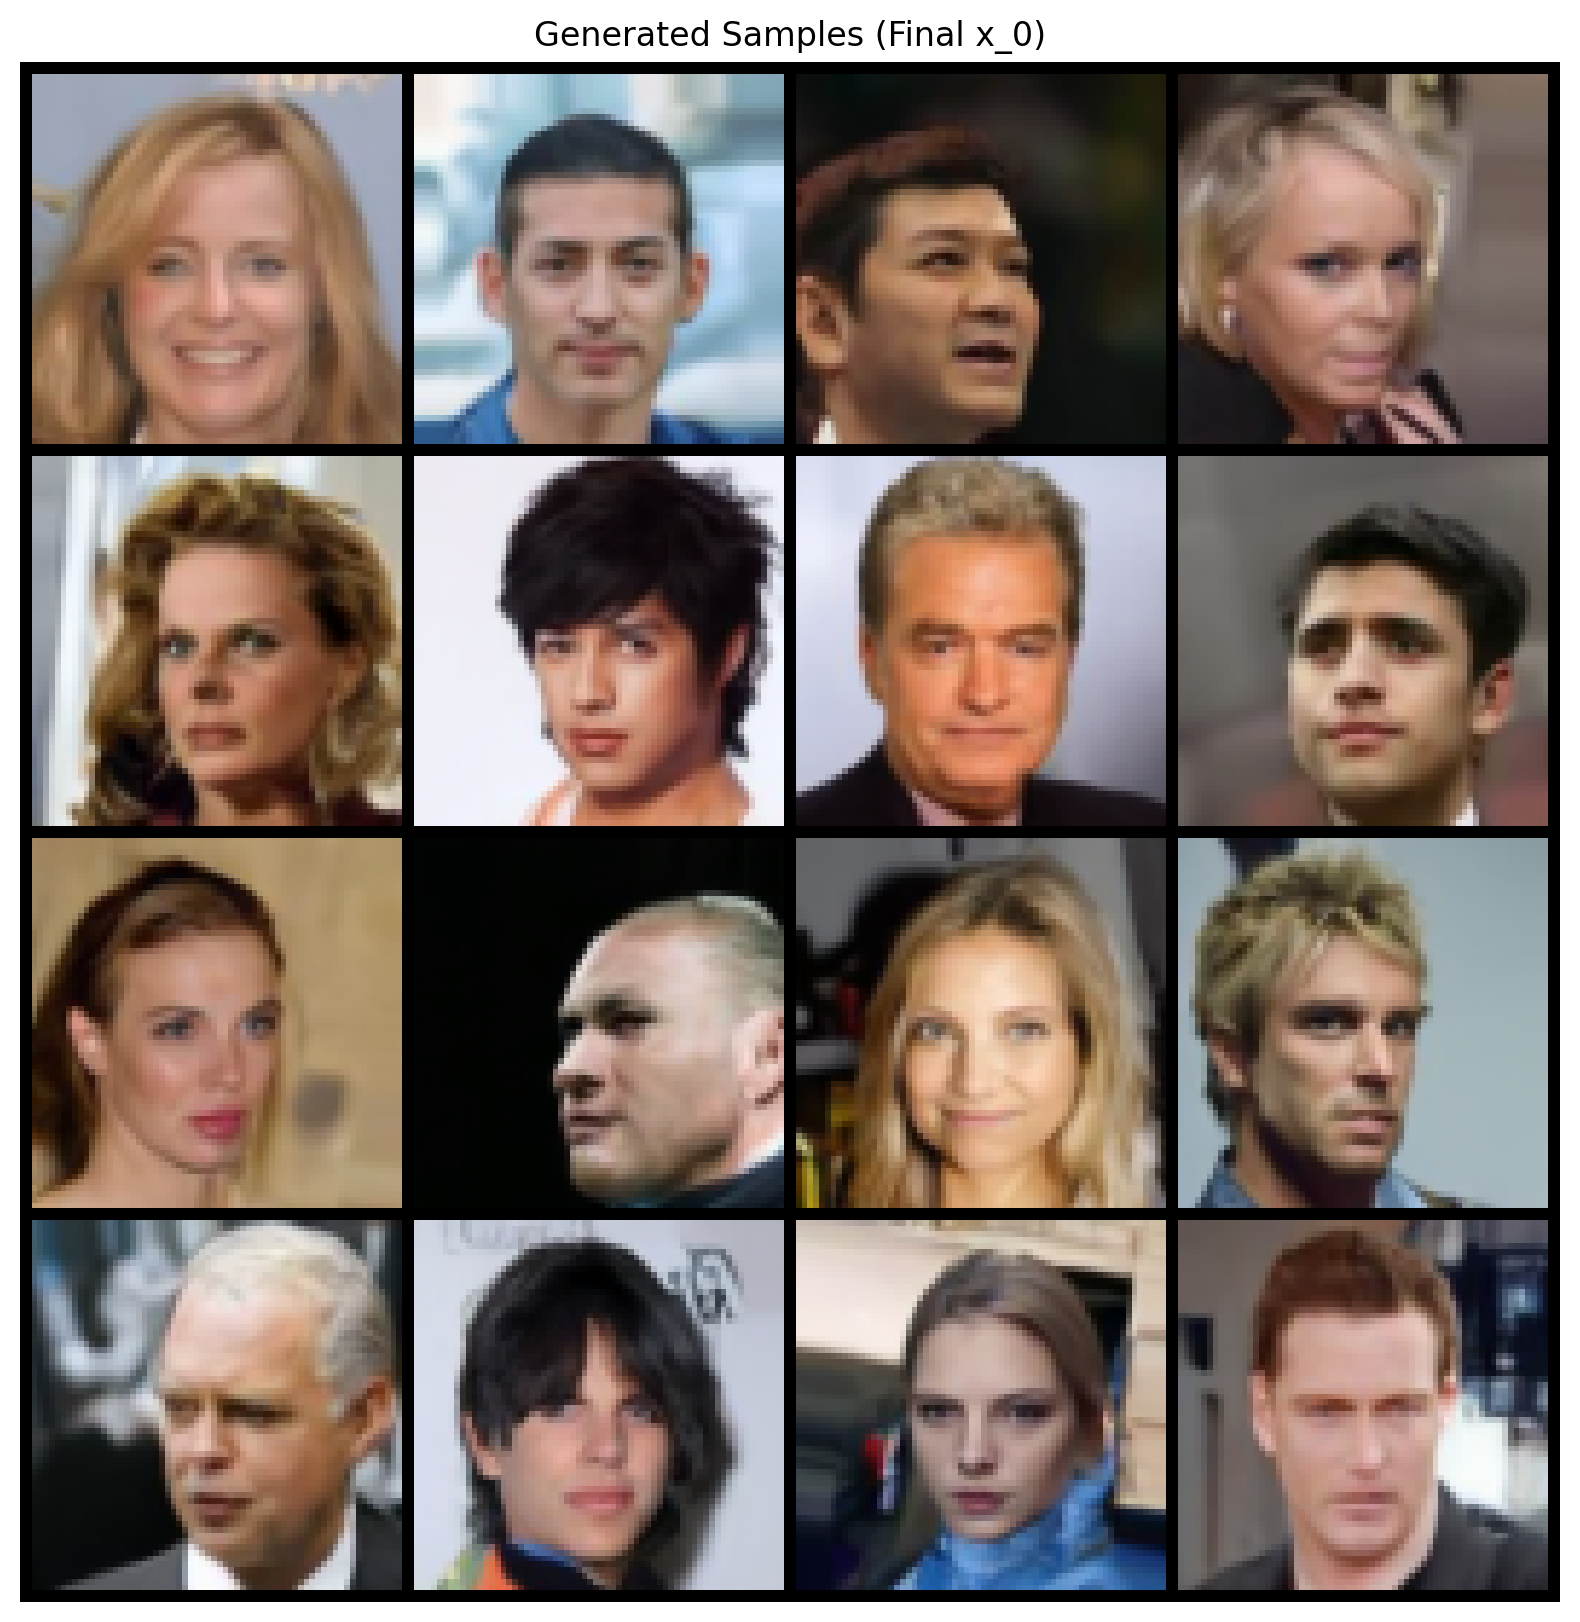

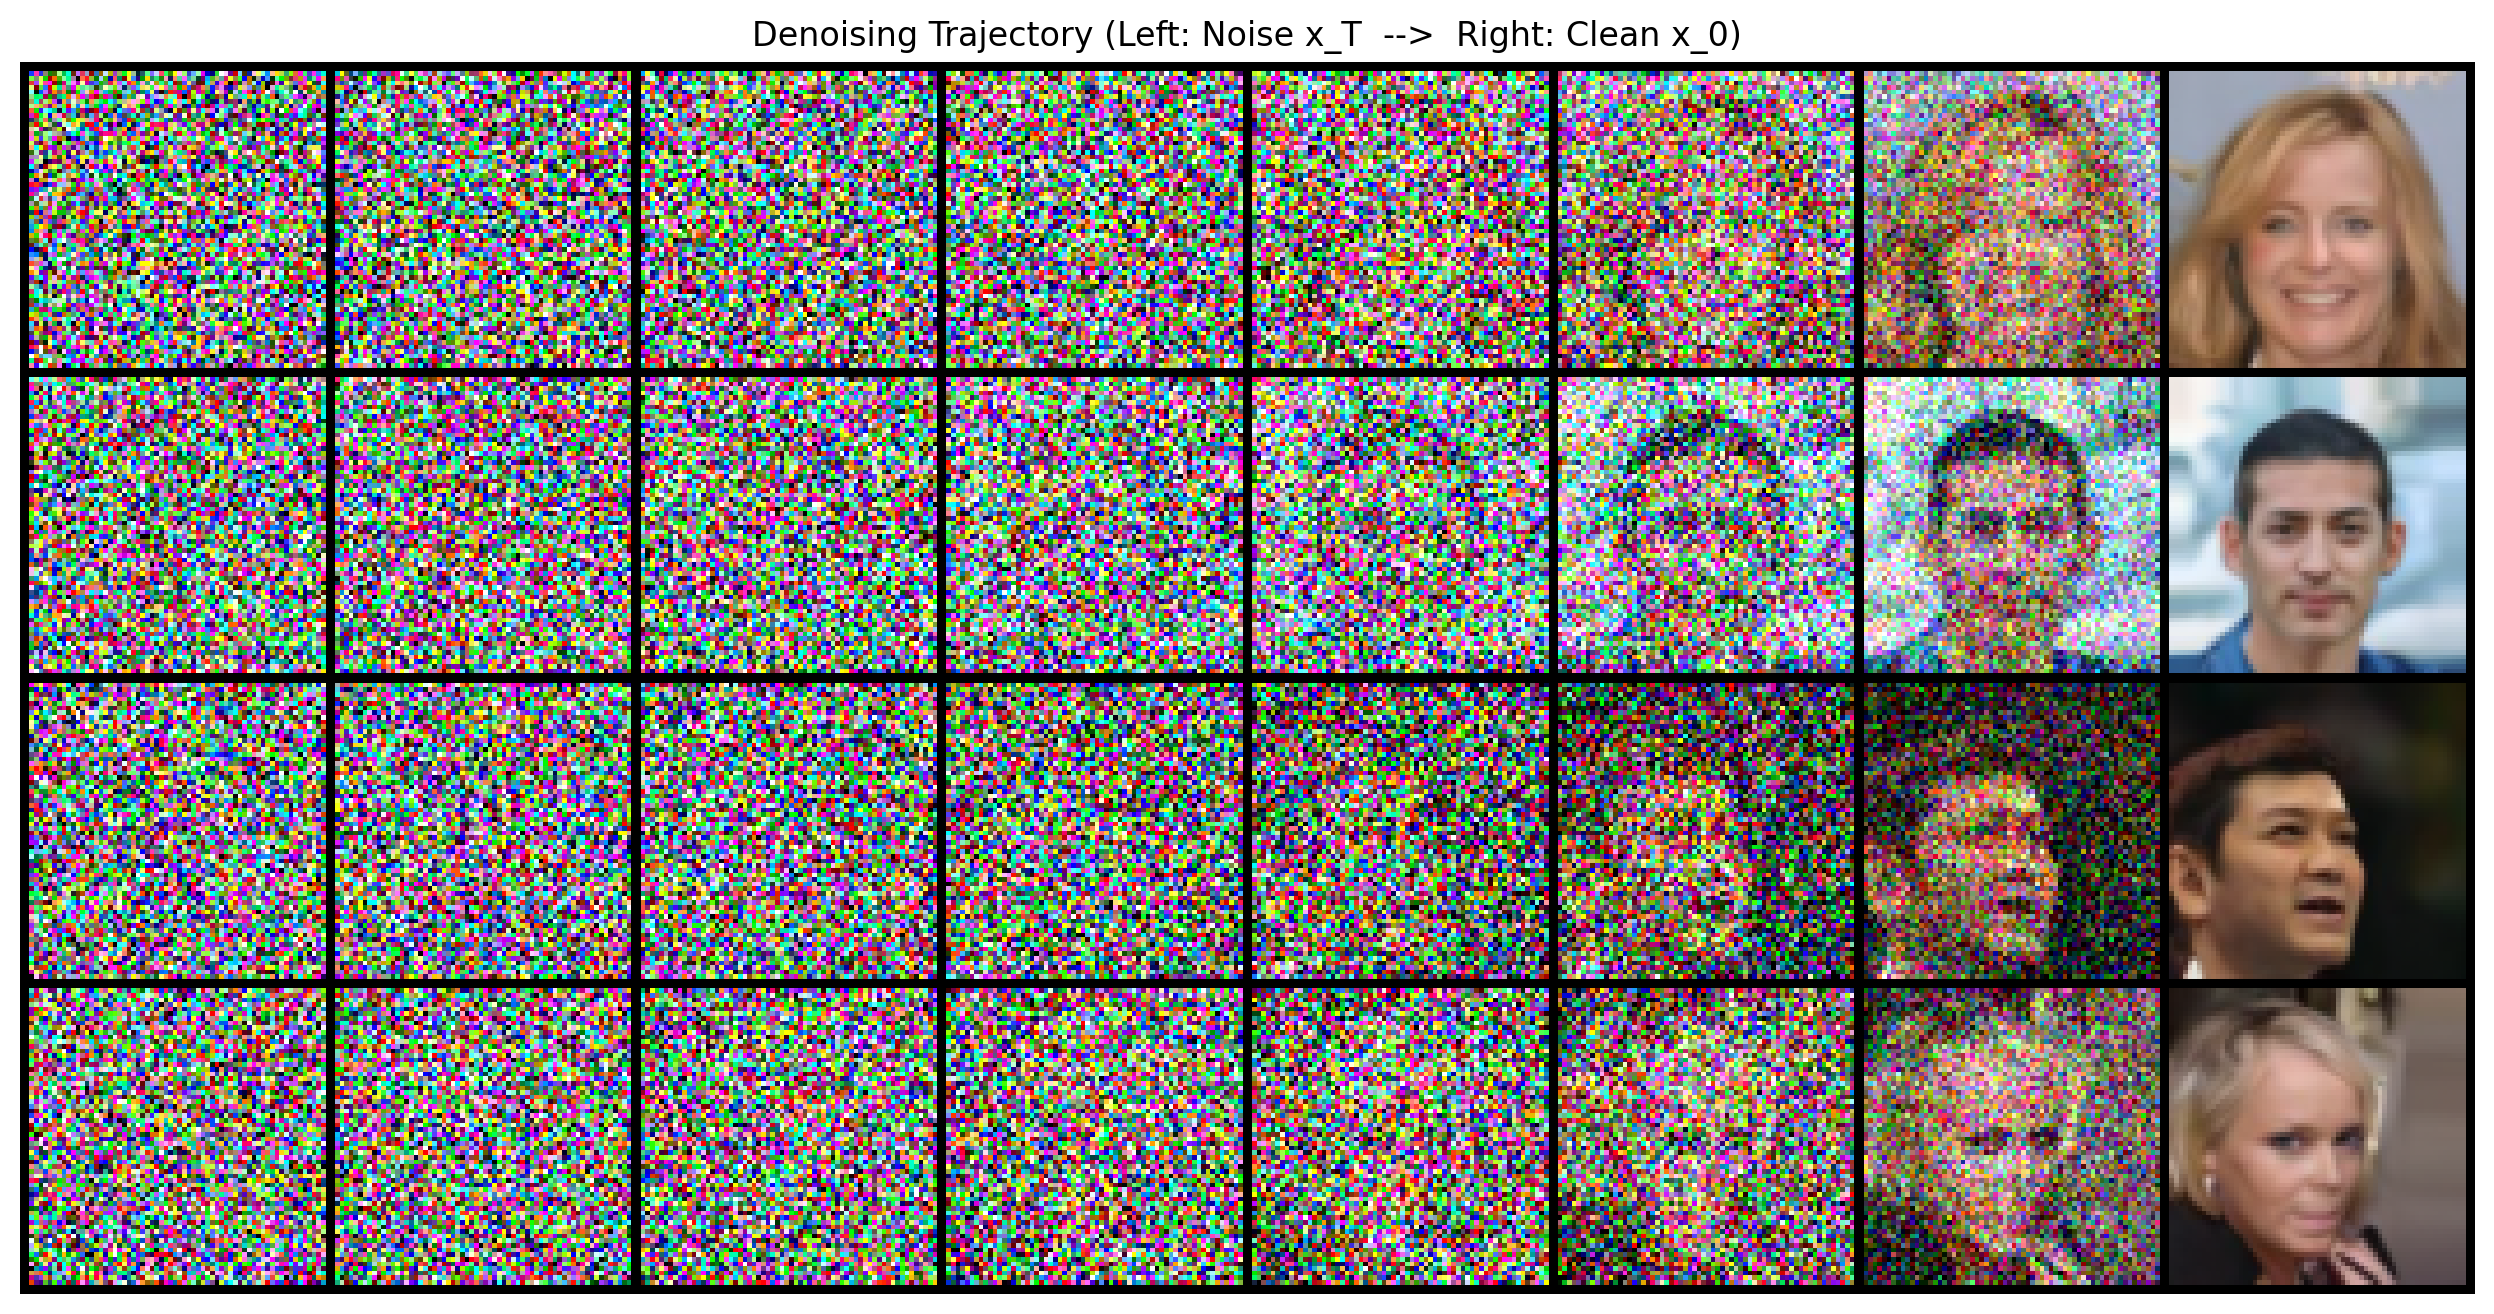

In [11]:
# Your DDPM sampling code
# -----------------------------------------------------------------------------
# 1. Configuration & Sampling
# -----------------------------------------------------------------------------
num_samples = 16
image_shape = (3, 64, 64)

print(f"Sampling with {METHOD}...")
print("This may take a minute...")

# Put model on correct device
diffusion.to(device)

# Run sampling
# DDPM.sample returns a list of tensors: [x_T, x_{T-1}, ..., x_0]
# where x_T is pure noise and x_0 is the final clean image.
with torch.no_grad():
    history = diffusion.sample(
        batch_size=num_samples,
        image_shape=image_shape,
        verbose=True,
        num_steps=1000
    )

# Convert history list to a single tensor: (TimeSteps, Batch, C, H, W)
# For DDPM 1000 steps, this will be [1001, 16, 3, 64, 64]
trajectory = torch.stack(history)
print(f"Trajectory shape: {trajectory.shape}")

# Helper to unnormalize images from [-1, 1] to [0, 1] for plotting
def unnormalize_to_zero_one(t):
    return (t + 1) * 0.5

# -----------------------------------------------------------------------------
# 2. Visualize Final Samples (The Grid)
# -----------------------------------------------------------------------------
# Take the last step (x_0)
final_samples = trajectory[-1].cpu()
final_samples = unnormalize_to_zero_one(final_samples).clamp(0, 1)

plt.figure(figsize=(10, 10))
plt.title("Generated Samples (Final x_0)")
# Create a 4x4 grid
final_grid = make_grid(final_samples, nrow=4, padding=2)
plt.imshow(final_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

# -----------------------------------------------------------------------------
# 3. Visualize Trajectory (Evolution from Noise to Data)
# -----------------------------------------------------------------------------
# We will show the evolution for the first 4 samples
num_show_samples = 4
num_time_steps_to_show = 8

# Pick evenly spaced timesteps from 0 (Noise) to End (Clean)
# Note: trajectory[0] is x_T (Noise), trajectory[-1] is x_0 (Clean)
time_indices = torch.linspace(0, len(trajectory) - 1, num_time_steps_to_show).long()

# Collect images: Rows = Samples, Cols = Time Steps
traj_images = []
for i in range(num_show_samples):
    for t in time_indices:
        traj_images.append(trajectory[t, i].cpu())

traj_tensor = torch.stack(traj_images)
traj_tensor = unnormalize_to_zero_one(traj_tensor).clamp(0, 1)

plt.figure(figsize=(20, 8))
plt.title("Denoising Trajectory (Left: Noise x_T  -->  Right: Clean x_0)")
# nrow=num_time_steps_to_show ensures each row is one sample evolving over time
traj_grid = make_grid(traj_tensor, nrow=num_time_steps_to_show, padding=2)
plt.imshow(traj_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()